In [1]:
!pip install tensorflow==2.12.0 tensorflow-addons
!pip install keras-resnet

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/272.9 MB ? eta -:--:--
   ---------------------------------------- 2.4/272.9 MB 12.2 MB/s eta 0:00:23
   ---------------------------------------- 3.4/272.9 MB 10.6 MB/s eta 0:00:26
    --------------------------------------- 5.2/272.9 MB 8.6 MB/s eta 0:00:32
   - -------------------------------------- 7.9/272.9 MB 9.5 MB/s eta 0:00:28
   - -------------------------------------- 10.2/272.9 MB 10.1 MB/s eta 0:00:26
   - -------------------------------------- 12.6/272.9 MB 10.4 MB/s eta 0:00:26
   -- ------------------------------------- 14.9/272.9 MB 10.6 MB/s eta 0:00:25
   -- ------------------------------------- 17.6/272.9 MB 10.8 MB/s eta 0:00:24
   -- ---

In [3]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 11.9 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------------------------------- ---- 2.4/2.7 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 11.9 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import keras_resnet

In [5]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='flower_photos',untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 20s 0us/step


In [6]:
batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

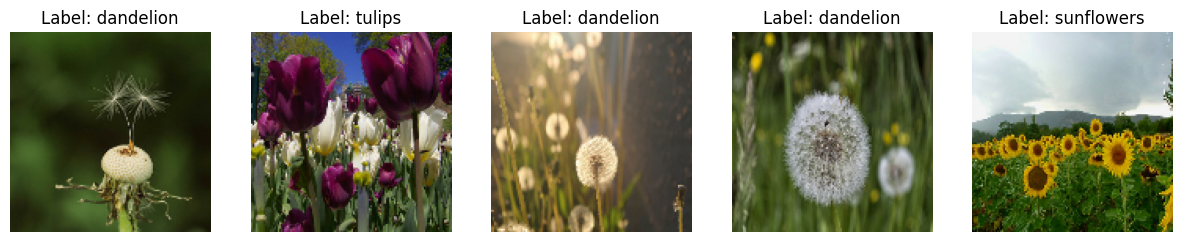

In [8]:
plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):  # 첫 배치에서 5장만 출력
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

In [9]:
from keras_resnet.models import ResNet18

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# 이 방식은 함수형 API 스타일로 사용 가능
base_model = ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True  # 파라미터 최소화 위해 depth=18, 필요시 일부만 학습

model = models.Sequential([
    data_augmentation,
    normalization_layer,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 8s 0us/step


In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
#학습
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
92/92 [==============================] - 96s 1s/step - loss: 0.3040 - accuracy: 0.8883 - val_loss: 0.6849 - val_accuracy: 0.7943
Epoch 2/10
92/92 [==============================] - 98s 1s/step - loss: 0.2723 - accuracy: 0.9005 - val_loss: 0.4689 - val_accuracy: 0.8678
Epoch 3/10
92/92 [==============================] - 98s 1s/step - loss: 0.2580 - accuracy: 0.9036 - val_loss: 1.1306 - val_accuracy: 0.7125
Epoch 4/10
92/92 [==============================] - 97s 1s/step - loss: 0.3522 - accuracy: 0.8719 - val_loss: 1.3709 - val_accuracy: 0.6308
Epoch 5/10
92/92 [==============================] - 96s 1s/step - loss: 0.2914 - accuracy: 0.8910 - val_loss: 0.8852 - val_accuracy: 0.7629
Epoch 6/10
92/92 [==============================] - 97s 1s/step - loss: 0.2495 - accuracy: 0.9019 - val_loss: 0.8616 - val_accuracy: 0.7861
Epoch 7/10
92/92 [==============================] - 96s 1s/step - loss: 0.2219 - accuracy: 0.9196 - val_loss: 0.6867 - val_accuracy: 0.8038
Epoch 8/10
92/92 [==

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                      

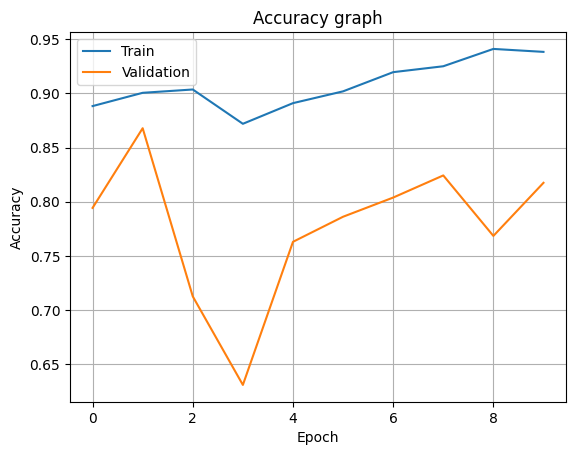

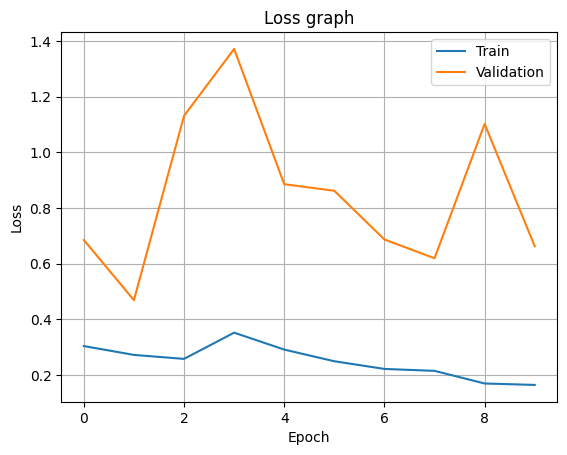

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
model.summary()
total_params = model.count_params()
print(f'총 파라미터 수: {total_params:,}')

# 학습 가능한 파라미터만 계산
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f'학습 가능한 파라미터 수: {trainable_params:,}')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

# 11. 모델 구조 그림 저장
keras.utils.plot_model(model, to_file="model_structure.png", show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['sequential[2][0]']             
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 64, 64)      53312       ['patches_1[0][0]']        

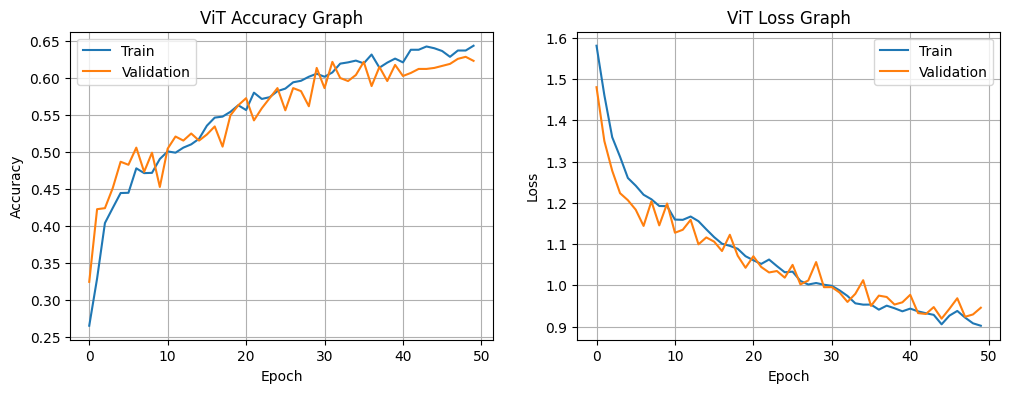

In [21]:
# ========= Vision Transformer (ViT) 모델 버전 =========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ViT 모델 구현을 위한 클래스 및 함수
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# ViT 모델 구축 함수
def create_vit_model(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    transformer_layers,
    num_heads,
    transformer_units,
    mlp_head_units,
    num_classes,
    dropout_rate=0.1
):
    inputs = layers.Input(shape=input_shape)

    # 데이터 증강
    augmented = data_augmentation(inputs)

    # 패치 생성 및 인코딩
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer 블록 생성
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Global average pooling
    representation = layers.GlobalAveragePooling1D()(representation)

    # Dropout
    representation = layers.Dropout(dropout_rate)(representation)

    # MLP 헤드
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout_rate)

    # 분류 헤드
    logits = layers.Dense(num_classes, activation='softmax')(features)

    # 모델 생성
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# ViT 하이퍼파라미터 설정 (경량화된 ViT-Tiny 수준)
input_shape = (img_height, img_width, 3)
patch_size = 16  # 각 패치의 크기
num_patches = (img_height // patch_size) * (img_width // patch_size)  # 패치 수
projection_dim = 64  # 임베딩 차원
transformer_layers = 6  # Transformer 블록 수
num_heads = 4  # 어텐션 헤드 수
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Transformer 블록 내 MLP 크기
mlp_head_units = [projection_dim, projection_dim // 2]  # 분류 헤드 MLP 크기

# ViT 모델 생성
vit_model = create_vit_model(
    input_shape=input_shape,
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    transformer_units=transformer_units,
    mlp_head_units=mlp_head_units,
    num_classes=len(class_names),
    dropout_rate=0.1
)

# ViT 모델 요약 및 파라미터 수 출력
vit_model.summary()
vit_total_params = vit_model.count_params()
print(f'ViT 모델 총 파라미터 수: {vit_total_params:,}')

# ViT 모델 컴파일
vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ViT 모델 학습
vit_history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# ViT 모델 평가
vit_res = vit_model.evaluate(val_ds, verbose=0)
print('ViT 모델 정확도 =', vit_res[1]*100)

# ViT 모델 정확도/손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vit_history.history['accuracy'])
plt.plot(vit_history.history['val_accuracy'])
plt.title('ViT Accuracy Graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(vit_history.history['loss'])
plt.plot(vit_history.history['val_loss'])
plt.title('ViT Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()


In [23]:
vit_mode.summary()
total_params = vit_mode.count_params()
print(f'총 파라미터 수: {total_params:,}')

# 학습 가능한 파라미터만 계산
trainable_params = sum([tf.keras.backend.count_params(w) for w in vit_mode.trainable_weights])
print(f'학습 가능한 파라미터 수: {trainable_params:,}')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

keras.utils.plot_model(vit_mode, to_file="model_structure.png", show_shapes=True)

NameError: name 'vit_mode' is not defined

In [24]:
# CNN/ResNet 모델 평가
res = model.evaluate(val_ds, verbose=0)
print('CNN/ResNet 정확도 =', res[1]*100)

# 이미 평가된 ViT 모델 결과와 함께 비교 (vit_res는 이미 정의되어 있다고 가정)
models_comparison = {
    'CNN/ResNet': {
        '파라미터 수': total_params,
        '정확도': res[1]*100
    },
    'ViT': {
        '파라미터 수': vit_total_params,
        '정확도': vit_res[1]*100
    }
}

for model_name, metrics in models_comparison.items():
    print(f"{model_name} - 파라미터 수: {metrics['파라미터 수']:,}, 정확도: {metrics['정확도']:.2f}%")


CNN/ResNet 정확도 = 81.74387216567993
CNN/ResNet - 파라미터 수: 23,597,957, 정확도: 81.74%
ViT - 파라미터 수: 559,045, 정확도: 62.26%
